<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Unsupervised/Notebooks/Unsupervised_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Final Pass

## Introduction


Western Australia's Department of Energy, Mines, Industry Regulation and Safety has a large datahub called GeoVIEW. It includes surveys, land use, geology, and drill holes among other geologic data. WA's geologic survey also developed a high-end automated spectral classification scanner, called HyLogger, which scans drill cores to detect minerology. Data for hundreds of drill core scans are available in GeoVIEW and this is where the data for this project was received. The HyLogger scans each meter of a core, measures thermal infrared (TIR) and short-wave infrared (SWIR) reflectance, and assigns mineral abundances within that meter for each wavelength range. Values for all detected minerals from TIR add to 1 and values for all minerals detected through SWIR add to 1. The Pilbara Craton in Western Australia has fascinating minerology, thus 16 drill holes within this region were selected for the project.

Drill hole data consists of 21 unique minerals, making analysis of the data difficult for those not well trained to expected or possible patterns and implications. Utilizing unsupervised learning methods, potential mineralogical patterns will be explored. Scoring methods will be used to develop optimal models and mineral formation research will determine whether these patterns make sense, are geologically consequential, or random groupings which hold no weight. Due to different geologic processes occurring in differing regions, holding to one region is necessary but should results prove useful, the same methods could be applied to other regions.

## Data Retrieval and Preprocessing

Preprocessing explanations and further data analysis are explored in the "Unsupervised EDA" notebook in this repository. As a quick summary, all 16 datasets are opened and combined, "N.A." values are filled with 0, and unneeded features/columns are removed.

In [55]:
import requests
import os
import pandas as pd
import glob

repo_api_url = "https://api.github.com/repos/GeoLinkCoding/EarthResources_DataScience/contents/Unsupervised/Data"
response = requests.get(repo_api_url).json()

# Extract filenames
files = [file["download_url"] for file in response if file["type"] == "file"]

# Download files
for file in files:
    os.system(f"wget {file}")

csv_files = glob.glob("*.csv")
dataframes = []
for file in csv_files:
  df = pd.read_csv(file,skiprows=16)
  df['filename'] = file[:-4]
  dataframes.append(df)
df_combined = pd.concat(dataframes).set_index('filename',append=True)

In [56]:
df_filled = df_combined.replace("N.A.",0)
non_numeric_cols = df_filled.select_dtypes(exclude=['number']).columns
for col in non_numeric_cols:
  df_filled[col] = pd.to_numeric(df_filled[col],errors='coerce')
col = df_filled.columns.tolist()
swir_num = [i for i in range(2,16)]
tir_num = [i for i in range(24,48)]
itors = swir_num + tir_num
good_cols = [col[c] for c in itors]
good_cols.append('Depth_from_(m)')
bad_cols = [c for c in col if c not in good_cols]
df_drop = df_filled.drop(columns=bad_cols)
df_drop = df_drop.drop(columns=['Misc-Silicate_(System_TIR)','Zeolite_(System_TIR)','Tourmaline_(System_TIR)'])

<ipython-input-56-d21f6e6e9159>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled = df_combined.replace("N.A.",0)


In [57]:
df_minerals = df_drop.copy()
df_minerals.head()

,,Depth_from_(m),Kaolin_(System_SWIR),White-Mica_(System_SWIR),Smectite_(System_SWIR),Other-AlOH_(System_SWIR),Chlorite_(System_SWIR),Dark-Mica_(System_SWIR),Amphibole_(System_SWIR),Serpentine_(System_SWIR),Other-MgOH_(System_SWIR),...,Dark-Mica_(System_TIR),Amphibole_(System_TIR),Serpentine_(System_TIR),Other-MgOH_(System_TIR),Epidote_(System_TIR),Carbonate_(System_TIR),Sulphate_(System_TIR),Phosphate_(System_TIR),Oxide_(System_TIR),INVALID_(System_TIR)
,filename,,,,,,,,,,,,,,,,,,,,,
0,SM_AIDP2,113.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.918782,0.0,0.0,0.000000,0.0
1,SM_AIDP2,114.0,0.00000,0.002358,0.009041,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.917282,0.0,0.0,0.000000,0.0
2,SM_AIDP2,115.0,0.00287,0.003494,0.000000,0.01063,0.087723,0.003079,0.0,0.0,0.0,...,0.001576,0.0,0.0,0.0,0.0,0.859063,0.0,0.0,0.000000,0.0
3,SM_AIDP2,116.0,0.00000,0.002113,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.924091,0.0,0.0,0.000000,0.0
4,SM_AIDP2,117.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.627326,0.0,0.0,0.000611,0.0


## Libraries used for Analysis

In [58]:
!pip install umap-learn

In [59]:
!pip install --upgrade numba llvmlite

In [60]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Standardization

Standardizing data is needed for unsupervised learning processes not to be biased to a specific feature.

Because the mineral relationships are being explored in this project, an extra dataset is created without the depth feature. Dimensionality reduction techniques will be performed on this dataset and depth will be added back for visualization and clustering.

In [61]:
standardized = StandardScaler().fit_transform(df_minerals)
df_standard = pd.DataFrame(standardized,columns=df_minerals.columns)
depth = df_standard['Depth_from_(m)']
df_nodepth = df_standard.drop(columns=['Depth_from_(m)'])
df_standard.head()

,Depth_from_(m),Kaolin_(System_SWIR),White-Mica_(System_SWIR),Smectite_(System_SWIR),Other-AlOH_(System_SWIR),Chlorite_(System_SWIR),Dark-Mica_(System_SWIR),Amphibole_(System_SWIR),Serpentine_(System_SWIR),Other-MgOH_(System_SWIR),...,Dark-Mica_(System_TIR),Amphibole_(System_TIR),Serpentine_(System_TIR),Other-MgOH_(System_TIR),Epidote_(System_TIR),Carbonate_(System_TIR),Sulphate_(System_TIR),Phosphate_(System_TIR),Oxide_(System_TIR),INVALID_(System_TIR)
0,-0.669233,-0.143572,-0.933771,-0.294572,-0.335837,-0.867820,-0.244005,-0.18985,-0.238264,-0.122075,...,-0.387710,-0.218998,-0.214153,-0.202953,-0.12474,3.660577,-0.256923,-0.077693,-0.163173,-0.120754
1,-0.664404,-0.143572,-0.926511,-0.099137,-0.335837,-0.867820,-0.244005,-0.18985,-0.238264,-0.122075,...,-0.387710,-0.218998,-0.214153,-0.202953,-0.12474,3.653750,-0.256923,-0.077693,-0.163173,-0.120754
2,-0.659575,-0.066742,-0.923015,-0.294572,1.123101,-0.595899,-0.120527,-0.18985,-0.238264,-0.122075,...,-0.292367,-0.218998,-0.214153,-0.202953,-0.12474,3.388716,-0.256923,-0.077693,-0.163173,-0.120754
3,-0.654747,-0.143572,-0.927265,-0.294572,-0.335837,-0.867820,-0.244005,-0.18985,-0.238264,-0.122075,...,-0.387710,-0.218998,-0.214153,-0.202953,-0.12474,3.684747,-0.256923,-0.077693,-0.163173,-0.120754
4,-0.649918,-0.143572,-0.933771,-0.294572,-0.335837,-0.867820,-0.244005,-0.18985,-0.238264,-0.122075,...,-0.387710,-0.218998,-0.214153,-0.202953,-0.12474,2.333767,-0.256923,-0.077693,-0.063113,-0.120754


## Principal Component Analysis

PCA combines features to produce a dataset with less features. This helps other machine learning processes produce better results on average and will show some correlations in the data. As the number of dimensions are reduced, the dataset becomes less similar to the original dataset. The explained variance metric shows how similar the new data is to the original and we want this metric to remain high.

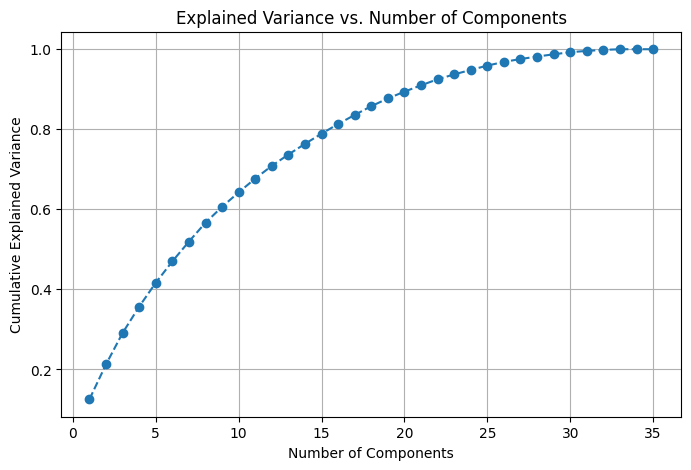

In [62]:
# Fit PCA on full dataset
pca = PCA()
pca.fit(df_nodepth)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

**Figure 1.** The cumulative explained variance over a range of dimensions. As the dimensions are further reduced, the dataset becomes less similar to the original. At 15 components, the new dataset has an explained variance of about 80%. This is the number of dimensions we will explore further.

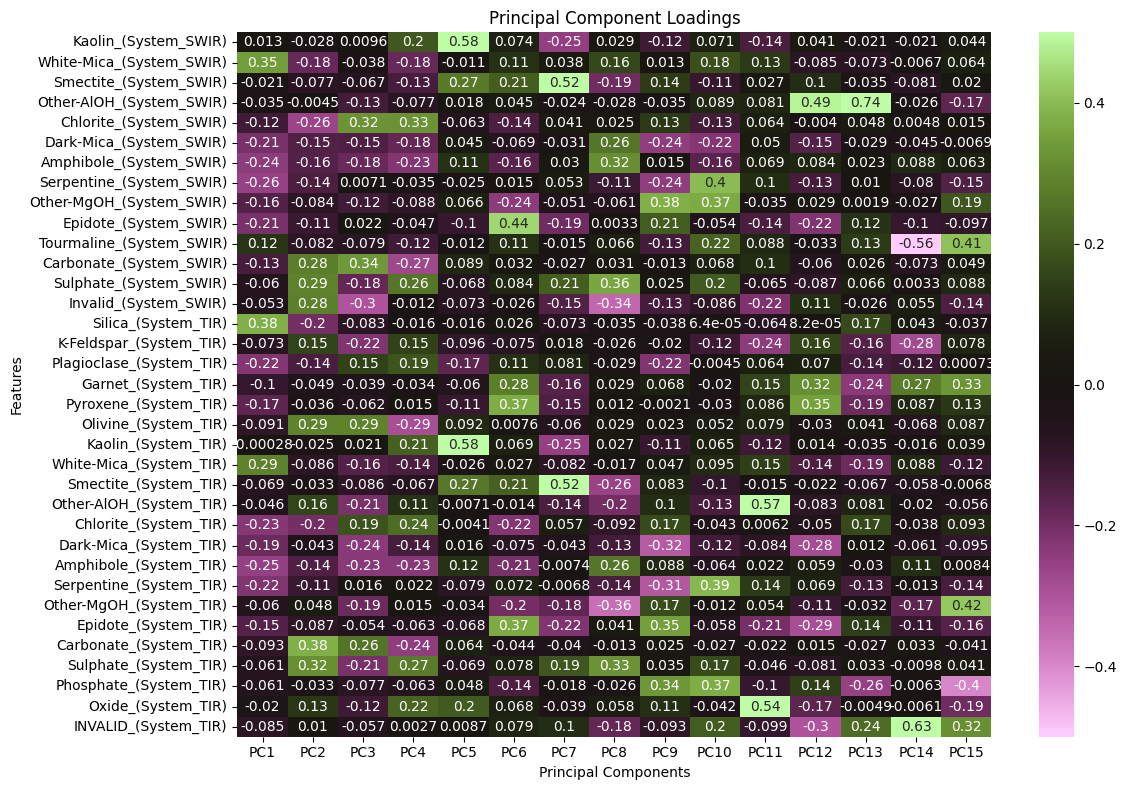

In [63]:
pca = PCA(n_components=15)  # Specify the number of PCs
pca_data = pca.fit_transform(df_nodepth)

# Create a DataFrame for loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(15)],
                        index=df_nodepth.columns)
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='vanimo', cbar=True, vmin=-0.5, vmax=0.5)
plt.title('Principal Component Loadings')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

**Figure 2.** The loadings matrix shows the correlations between each feature from the original dataset and the principal components from PCA. Features in green are positively correlated with a component and those in purple are negatively correlated. With an increase in a component there is an associated increase or decrease in each feature. We see most minerals with a SWIR and TIR feature have an almost equivalent correlation within the same component, so we know the results are fairly good. The SWIR and TIR invalid features are not similar like the others; these represent unclassified minerals, and we can correctly assume that minerals between these categories are not the same.

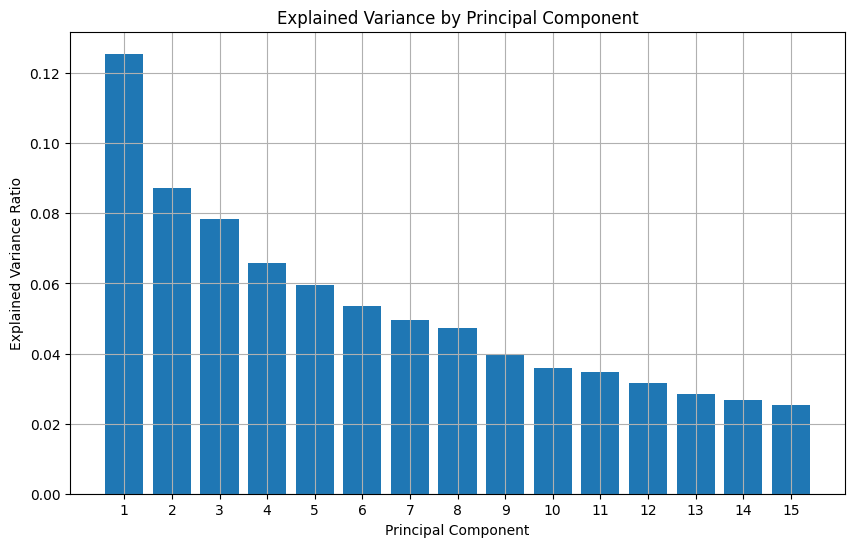

In [64]:
explained_variance_ratios = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.xticks(range(1, len(explained_variance_ratios) + 1))
plt.grid(True)
plt.show()

**Figure 3.** Each component makes up the total dataset variance differently. Starting with PC1, the new features are in order of greatest relatability to the original data to the lowest at PC15.

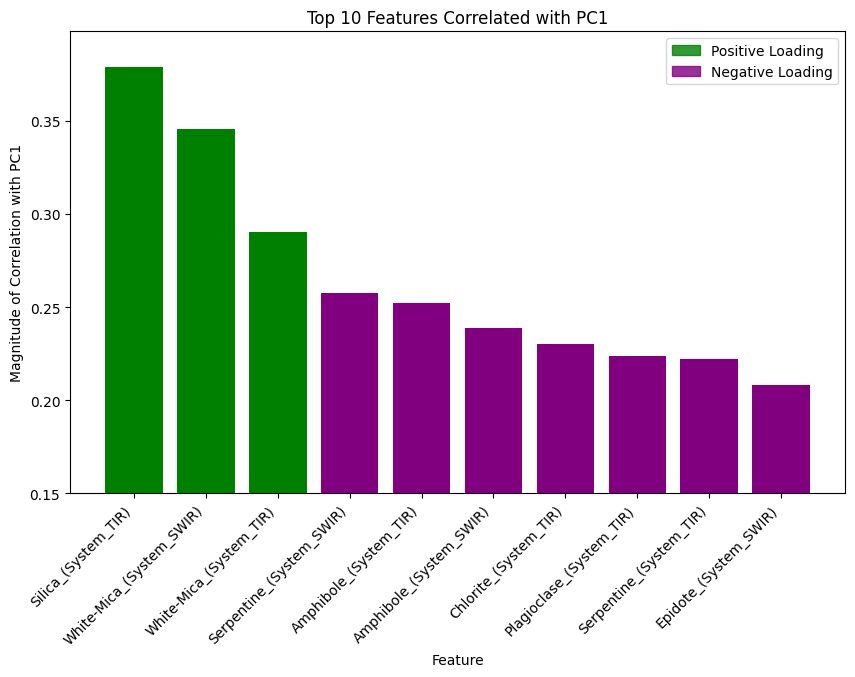

In [65]:
# Get absolute values to rank by magnitude
top_features = loadings['PC1'].abs().nlargest(10).index
top_loadings = loadings.loc[top_features, 'PC1']

# Sort by absolute magnitude
top_loadings = top_loadings.reindex(top_loadings.abs().sort_values(ascending=False).index)

# Set colors: green for positive, purple for negative
colors = ['green' if x > 0 else 'purple' for x in top_loadings]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_loadings.index, top_loadings.abs(), color=colors)
plt.xlabel('Feature')
plt.ylabel('Magnitude of Correlation with PC1')
plt.title('Top 10 Features Correlated with PC1')
plt.ylim(0.15)
plt.xticks(rotation=45, ha='right')
positive_handle = plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.8)  # Create a green rectangle
negative_handle = plt.Rectangle((0, 0), 1, 1, color='purple', alpha=0.8) # Create a purple rectangle

# Add legend
plt.legend([positive_handle, negative_handle], ['Positive Loading', 'Negative Loading'])
# Show plot
plt.show()

**Figure 4.** The top ten correlated features with PC1 by magnitude. As this component increases, silica and white-mica tend to increase in abundance as well, while other minerals like serpentine and amphibole tend to decrease.

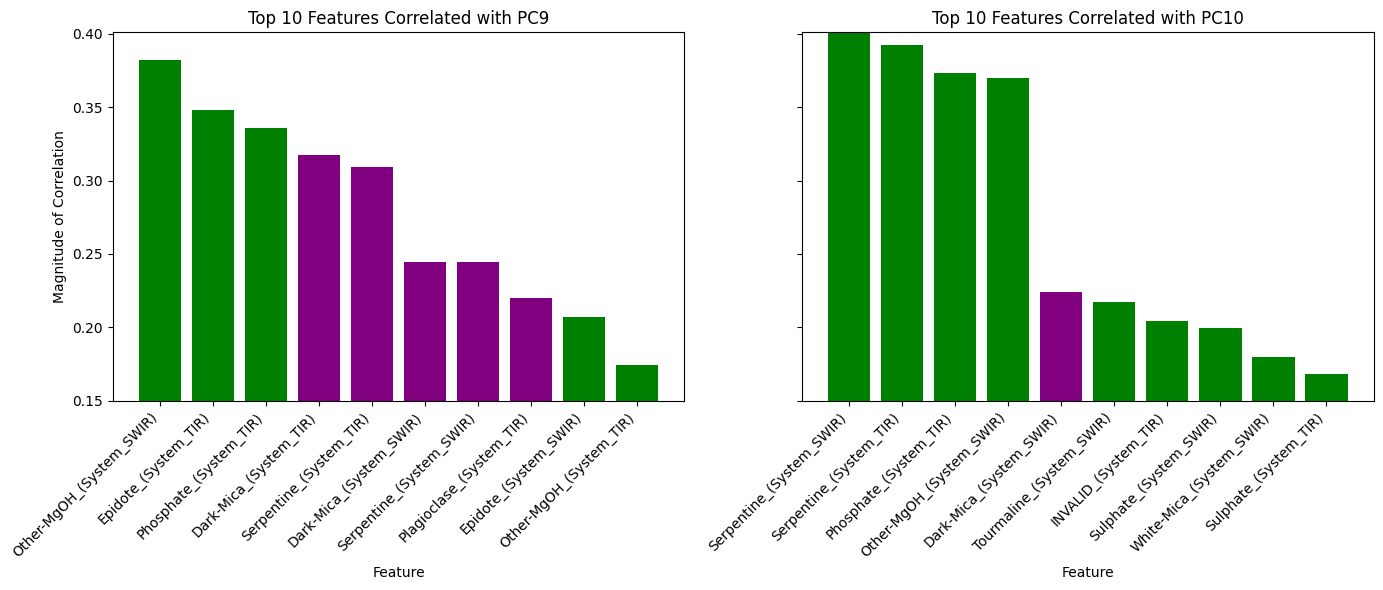

In [66]:
top_features_9 = loadings['PC9'].abs().nlargest(10).index
top_loadings_9 = loadings.loc[top_features_9, 'PC9']
top_features_10 = loadings['PC10'].abs().nlargest(10).index
top_loadings_10 = loadings.loc[top_features_10, 'PC10']

# Sort by absolute magnitude
top_loadings_9 = top_loadings_9.reindex(top_loadings_9.abs().sort_values(ascending=False).index)
top_loadings_10 = top_loadings_10.reindex(top_loadings_10.abs().sort_values(ascending=False).index)

# Set colors: green for positive, purple for negative
colors_9 = ['green' if x > 0 else 'purple' for x in top_loadings_9]
colors_10 = ['green' if x > 0 else 'purple' for x in top_loadings_10]

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bar plot for PC9
axes[0].bar(top_loadings_9.index, top_loadings_9.abs(), color=colors_9)
axes[0].set_title('Top 10 Features Correlated with PC9')
axes[0].set_ylabel('Magnitude of Correlation')
axes[0].set_xlabel('Feature')
axes[0].set_ylim(0.15)
axes[0].set_xticks(range(len(top_loadings_9.index)),labels=top_loadings_9.index,rotation=45, ha='right')

# Bar plot for PC10
axes[1].bar(top_loadings_10.index, top_loadings_10.abs(), color=colors_10)
axes[1].set_title('Top 10 Features Correlated with PC10')
axes[1].set_xlabel('Feature')
axes[1].set_ylim(0.15)
axes[1].set_xticks(range(len(top_loadings_10.index)),labels=top_loadings_10.index,rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

**Figure 5.** Components 9 and 10 had an interesting relationship to explore. Serpentine has a strong positive correlation to PC10 and a strong negative correlation to PC9, yet phosphate and other-MgOH have a strong positive correlation to both. We'll explore this relationship further.

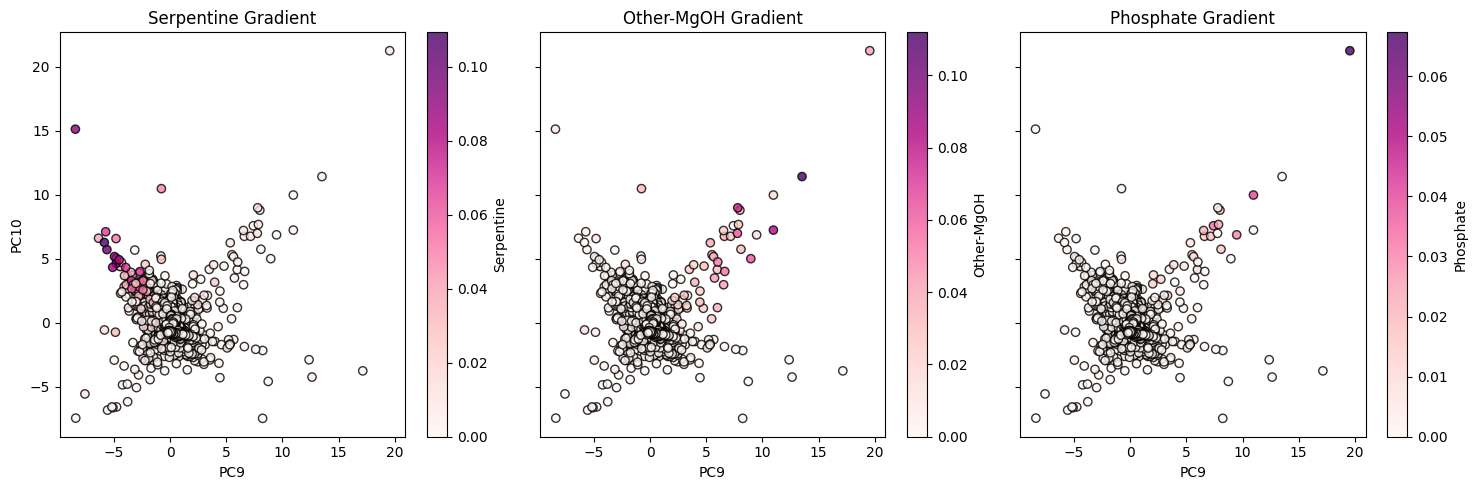

In [67]:
pc_9 = pca_data[:,8]
pc_10 = pca_data[:,9]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Scatter plot with Serpentine gradient
im1 = axes[0].scatter(pc_9, pc_10,
                     c=df_minerals['Serpentine_(System_TIR)'], cmap='RdPu', edgecolor='k', alpha=0.8)
fig.colorbar(im1, ax=axes[0], label='Serpentine')
axes[0].set_xlabel('PC9')
axes[0].set_ylabel('PC10')
axes[0].set_title('Serpentine Gradient')

# Scatter plot with Other-MgOH gradient
im2 = axes[1].scatter(pc_9, pc_10,
                     c=df_minerals['Other-MgOH_(System_SWIR)'], cmap='RdPu', edgecolor='k', alpha=0.8)
fig.colorbar(im2, ax=axes[1], label='Other-MgOH')
axes[1].set_xlabel('PC9')
axes[1].set_title('Other-MgOH Gradient')

# Scatter plot with Phosphate gradient
im3 = axes[2].scatter(pc_9, pc_10,
                     c=df_minerals['Phosphate_(System_TIR)'], cmap='RdPu', edgecolor='k', alpha=0.8)
fig.colorbar(im3, ax=axes[2], label='Phosphate')
axes[2].set_xlabel('PC9')
axes[2].set_title('Phosphate Gradient')

plt.tight_layout()
plt.show()

**Figure 6.** Most data points have these abundances at zero or close to. None of these minerals/rock get very high abundances but we can observe the slopes of the gradients to confirm the correlations from the loadings matrix. Serpentine has a negative slope between PC9 and PC10 while the other two have positive slopes. Another observation is that data points with a bit higher abundance with one of three minerals/rock show very low or no abundance for the others. We'll explore the direct relationships between these features next.

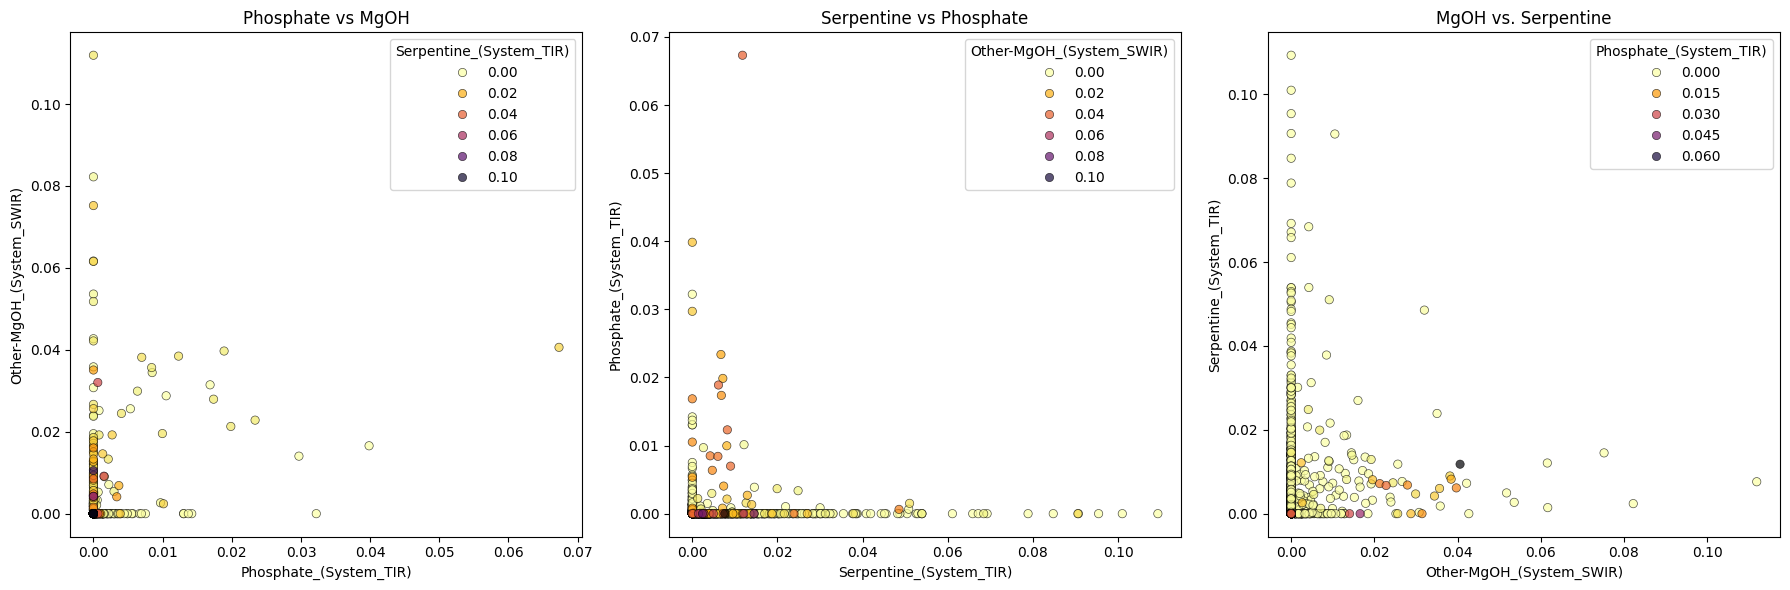

In [68]:
df_minerals_serpentine = df_minerals.sort_values(by=['Serpentine_(System_TIR)'])
df_minerals_phosphate = df_minerals.sort_values(by=['Phosphate_(System_TIR)'])
df_minerals_mgoh = df_minerals.sort_values(by=['Other-MgOH_(System_SWIR)'])
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Normal Scale with Serpentine Gradient
sns.scatterplot(x='Phosphate_(System_TIR)', y='Other-MgOH_(System_SWIR)',
                hue='Serpentine_(System_TIR)', data=df_minerals_serpentine,
                palette='inferno_r', ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].set_title('Phosphate vs MgOH')


sns.scatterplot(x='Serpentine_(System_TIR)', y='Phosphate_(System_TIR)',
                hue='Other-MgOH_(System_SWIR)', data=df_minerals_mgoh,
                palette='inferno_r', ax=axes[1], edgecolor='black', alpha=0.7)
axes[1].set_title('Serpentine vs Phosphate')

sns.scatterplot(x='Other-MgOH_(System_SWIR)', y='Serpentine_(System_TIR)',
                hue='Phosphate_(System_TIR)', data=df_minerals_phosphate,
                palette='inferno_r', ax=axes[2], edgecolor='black', alpha=0.7)
axes[2].set_title('MgOH vs. Serpentine')
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Figure 7.** These three minerals/rock have very low abundances throughout the dataset. Interestingly, serpentine and other-MgOH minerals have significantly more concurrent appearances in these cores than phosphate does, meaning these two materials will more often be in the same 1-meter column than phosphate would with either of them. Mineral/rock formation literature states that serpentine is a metamorphic rock formed at ocean floors in mid-ocean ridges and subduction zones, and MgOH base minerals, like brucite with formula $Mg(OH)_2$, also generally form through metamorphic processes, with the mentioned brucite occasionally being a component in serpentine rocks. On the other hand, while phosphates also form in oceanic settings, their formation is due to sedimentary processes.

#### PCA Conclusions:

PCA loadings displayed some potential relationships we would miss through the original correlation heatmap from the exploratory data analysis in another notebook. Among the possibilities, PC9 and PC10 were chosen for further study due to the unique correlations which showed opposing correlations to serpentine when two others were in tandem. Exploring these it was observed that the opposing correlations are due to serpentine abundances coinciding significantly more with one of these minerals than the other. This pressed literature study into their formations which revealed similar formations for the two mineral/rock types with higher concurrent abundances than the other mineral. We would expect these two materials to occur together more often than others, the data demonstrate this correlation, and it was because of PCA that I was able to discover this for myself. This gives credence to PCA being a reliable method for less studied geologists to find patterns they can further explore to enhance their knowledge in mineralogy.

## Uniform Manifold Approximation and Projection

UMAP is another dimensionality reduction technique like PCA but where it differs is its ability to handle complex relationships. Where PCA explores linear relationships, UMAP explores non-linear. The downside to this is feature importance and loading matrices are not available to show how individual features play into the derived UMAP components; however, there are other ways to explore the results.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


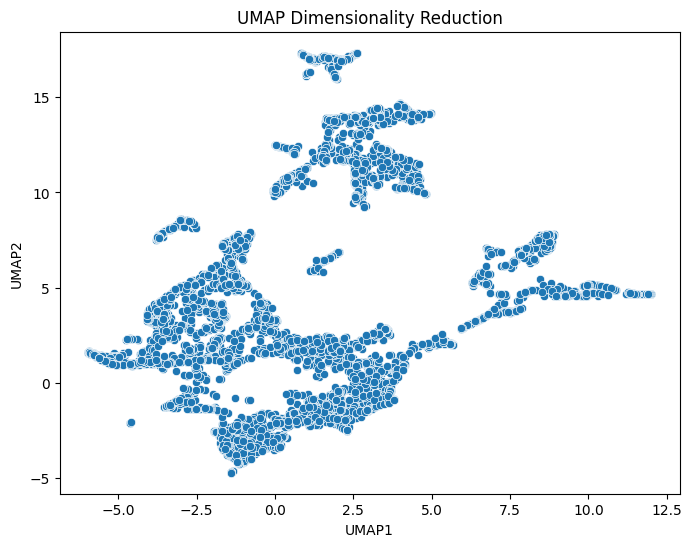

In [69]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(df_nodepth)
df_umap = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', data=df_umap)
plt.title('UMAP Dimensionality Reduction')
plt.show()

**Figure 8.** Reducing the data into just two features produces this dataset. The ease of visualization with this data, where no significant outliers skew axis ranges, gives credence to this method's ability to process the complex dataset it was given.

In [70]:
score_pca = trustworthiness(df_nodepth, pca_data, n_neighbors=5)
score_umap = trustworthiness(df_nodepth, embedding, n_neighbors=5)
print(f"Trustworthiness Score (PCA): {score_pca:.4f}")
print(f"Trustworthiness Score (UMAP): {score_umap:.4f}")

Trustworthiness Score (PCA): 0.9973
Trustworthiness Score (UMAP): 0.9811


Scoring metrics often used with PCA aren't applicable with UMAP due to the differences in computation methods. However, we can use trustworthiness, which compares closeness between data points from the original and reduced data. The trustworthiness from the 15 features from PCA and these two new features from UMAP both have values very close to one, so this method, like PCA, did well to retain similar relationships as the original.

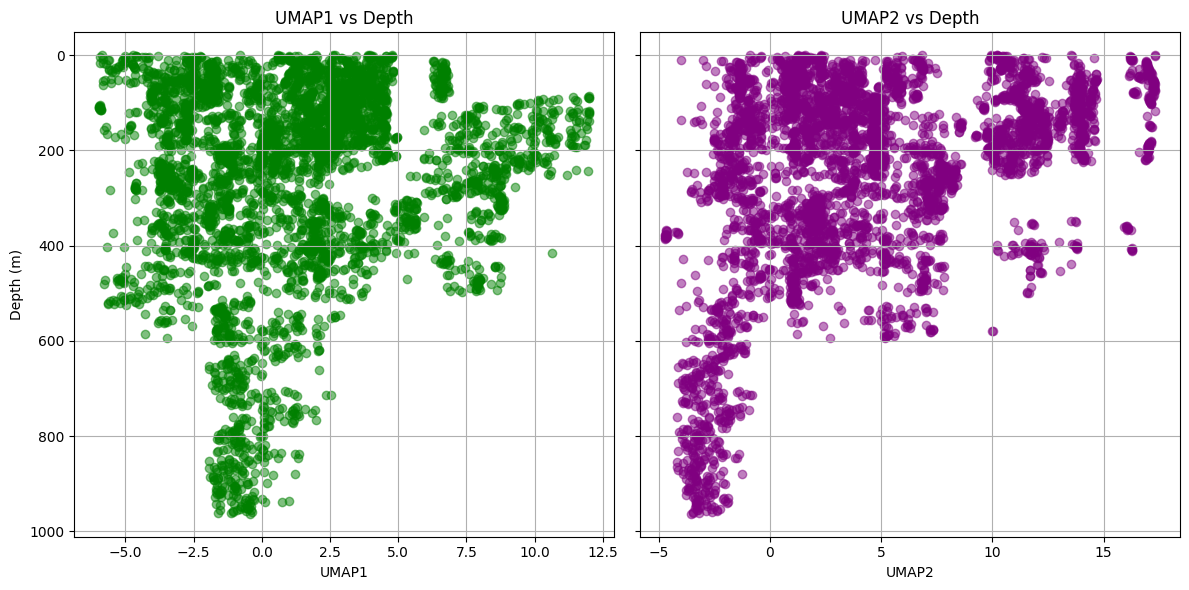

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns

# Plot UMAP1 vs Depth on the first subplot (ax1)
scatter1 = ax1.scatter(df_umap['UMAP1'], df_minerals['Depth_from_(m)'],alpha=0.5, c='g')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('Depth (m)')
ax1.set_title('UMAP1 vs Depth')
ax1.grid(True)

# Plot UMAP2 vs Depth on the second subplot (ax2)
scatter2 = ax2.scatter(df_umap['UMAP2'], df_minerals['Depth_from_(m)'],alpha=0.5, c='purple')
ax2.set_xlabel('UMAP2')
ax2.set_title('UMAP2 vs Depth')
ax2.grid(True)

plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Figure 9.** With two features, instead of 15 or 35, we can much more easily plot relationships. This figure shows each UMAP component compared to depth.

### KMeans with UMAP

KMeans is a clustering method that groups data points based on their closeness to each other and  how many groups it's told to make. In the first pass, KMeans was explored with the 15 PCA reduced features and results were not helpful to the use case for this project. With only 2 features from UMAP, we'll explore KMeans again and see if we get more informative and meaningful clusters.

In [79]:
def avg_silhouette_scores(data, cluster_range, n_iterations=25):
    avg_silhouette_scores = []
    for n_clusters in cluster_range:
        scores = []
        for _ in range(n_iterations):
            kmeans = KMeans(n_clusters=n_clusters, random_state=None)  # Random state is not fixed for variability
            labels = kmeans.fit_predict(data)
            score = silhouette_score(data, labels)
            scores.append(score)
        avg_silhouette_scores.append(np.mean(scores))
    return avg_silhouette_scores

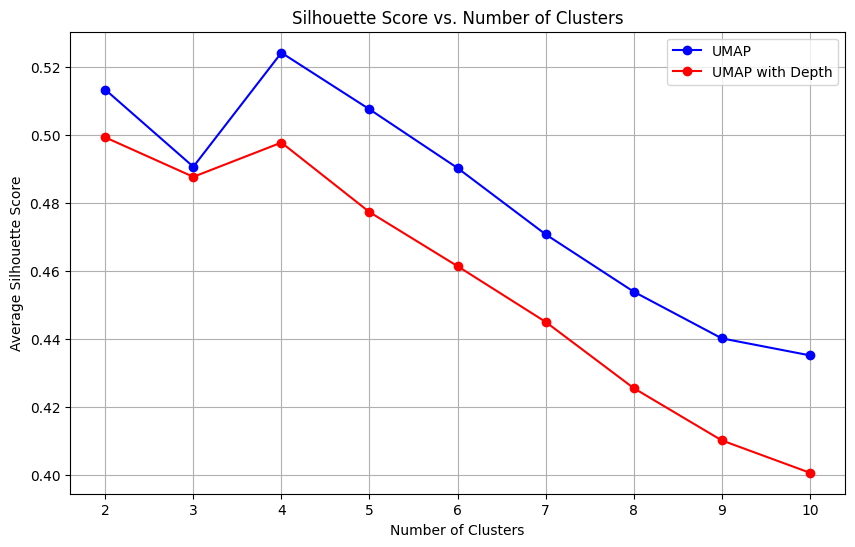

In [80]:
df_umap_depth = df_umap.copy()
df_umap_depth['Depth'] = df_standard['Depth_from_(m)']

cluster_range = range(2, 11)  # Minimum of 2 clusters for silhouette score
silhouette_scores_nodepth = avg_silhouette_scores(df_umap, cluster_range)
silhouette_scores_depth = avg_silhouette_scores(df_umap_depth, cluster_range)
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_nodepth, marker='o', linestyle='-', color='b',label='UMAP')
plt.plot(cluster_range, silhouette_scores_depth, marker='o', linestyle='-', color='r',label='UMAP with Depth')
plt.xticks(cluster_range)
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.legend()
plt.show()

**Figure 10.** Silhouette score compares how close each data point is to others in its cluster and how far it is from different clustered points. Since clustering outputs different results each time it's run, without a random state, kmeans was applied to two datasets 10 times for each n_clusters ranged 2-10. This figure displays the average score for each number of clusters. UMAP was performed on only mineral abundance data, so a second dataset was added with the depth feature attached to the UMAP data. Four clusters tends to be the highest performing for both, further indicating good reduction results, and the dataset with only the two UMAP components had average silhouette scores of about 0.5, which is considered good.

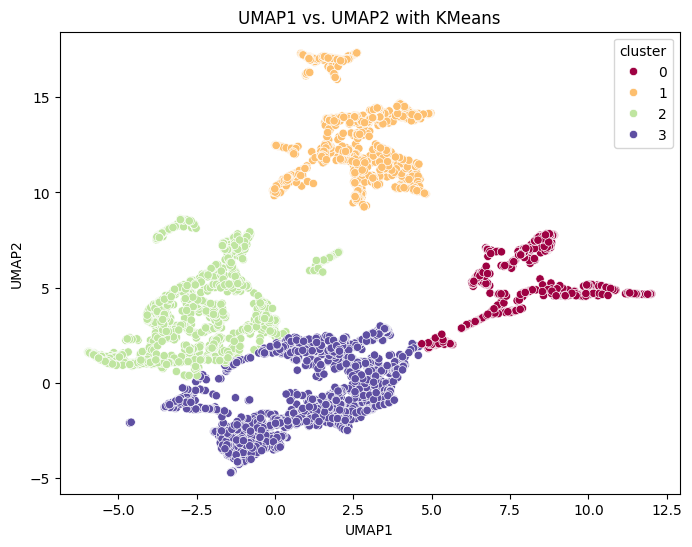

In [74]:
kmeans = KMeans(n_clusters=4, random_state=42)  # Set random_state for reproducibility

# Fit KMeans to the UMAP data
kmeans.fit(df_umap[['UMAP1', 'UMAP2']])  # Use only UMAP dimensions

# Get cluster assignments
cluster_labels = kmeans.labels_
df_umap['cluster'] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=df_umap, palette='Spectral')  # Use 'palette' for color scheme
plt.title('UMAP1 vs. UMAP2 with KMeans')
plt.show()

**Figure 11.** This figure shows the two components against each other again but with four cluster groupings. From visual inspection this clustering looks good. This dataset is the one without the depth feature.

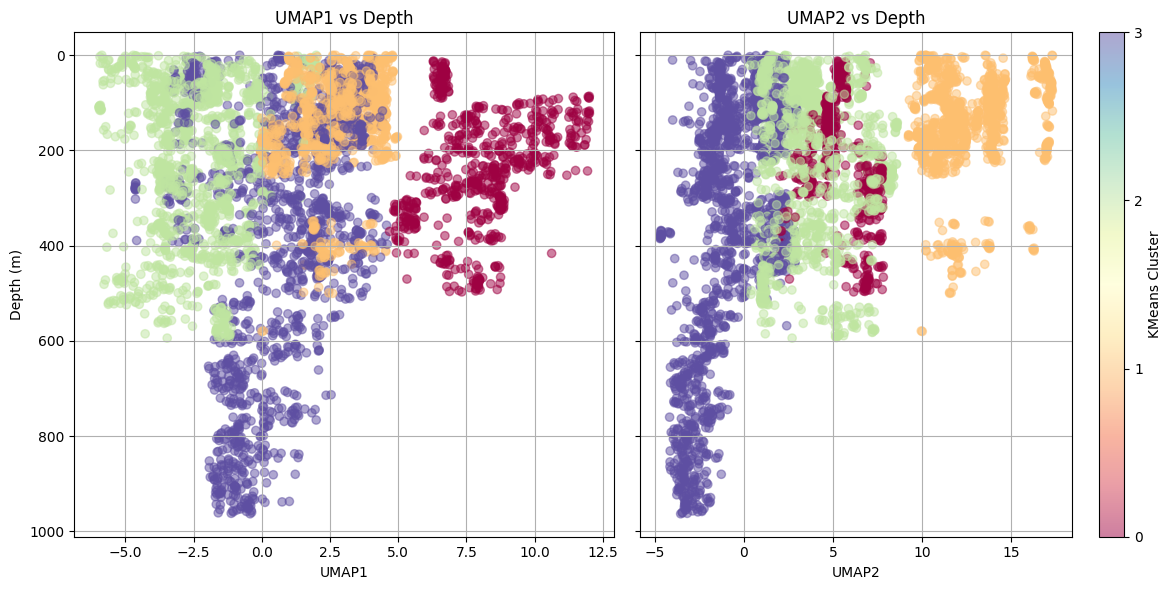

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns

# Plot UMAP1 vs Depth on the first subplot (ax1)
scatter1 = ax1.scatter(df_umap['UMAP1'], df_minerals['Depth_from_(m)'],alpha=0.5, c=df_umap['cluster'], cmap='Spectral')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('Depth (m)')
ax1.set_title('UMAP1 vs Depth')
ax1.grid(True)

# Plot UMAP2 vs Depth on the second subplot (ax2)
scatter2 = ax2.scatter(df_umap['UMAP2'], df_minerals['Depth_from_(m)'],alpha=0.5, c=df_umap['cluster'], cmap='Spectral')
ax2.set_xlabel('UMAP2')
ax2.set_title('UMAP2 vs Depth')
ax2.grid(True)

cbar = fig.colorbar(scatter1, ax=ax2)
cbar.set_label('KMeans Cluster')
cbar.ax.set_yticks([0, 1, 2, 3],['0','1','2','3'])

plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Figure 12.** Plotting these components and their clusters over depth further shows how well the cluster algorithm did. One cluster dominates data with depth under 600 meters, this is especially compelling because depth was not a feature used in the reduction or clustering algorithms.

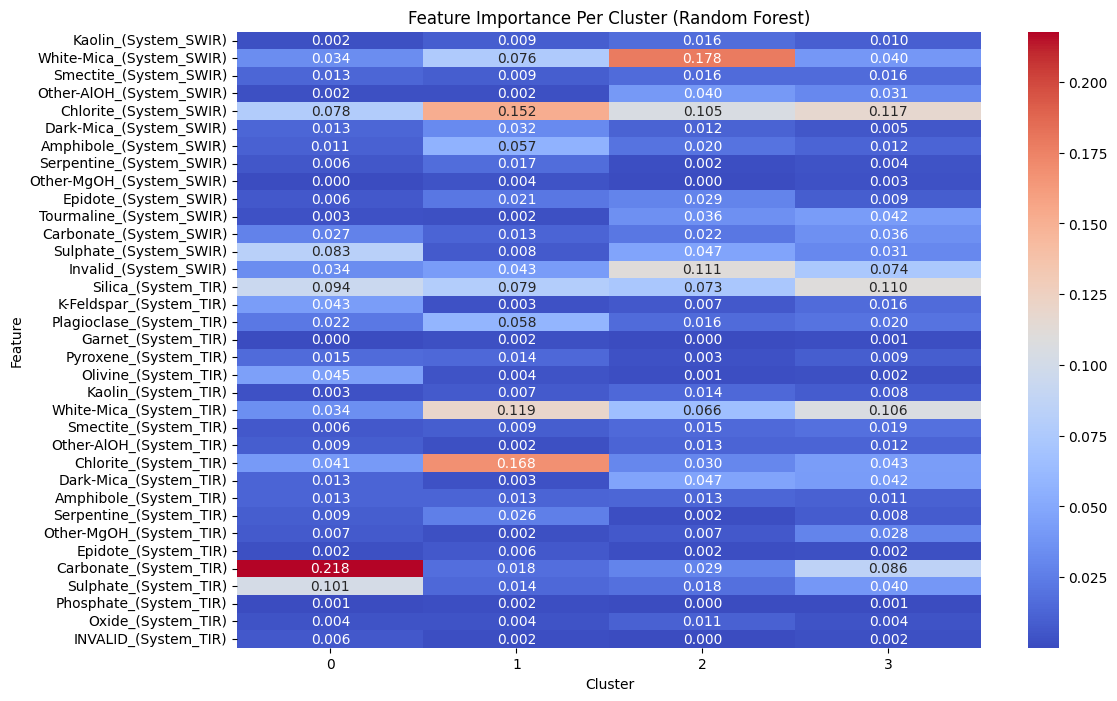

In [76]:
normalized = Normalizer().fit_transform(df_minerals.drop(columns=['Depth_from_(m)']))
df_normal = pd.DataFrame(normalized,columns=df_minerals.drop(columns=['Depth_from_(m)']).columns)
df_normal['cluster'] = cluster_labels

X = df_normal.drop(columns=['cluster'])
y = df_normal['cluster']
clusters = sorted(y.unique())  # Get unique cluster labels

# Store feature importance for each cluster
feature_importance_df = pd.DataFrame(index=X.columns, columns=clusters)

# Train a separate Random Forest for each cluster (One-vs-All)
for cluster in clusters:
    y_binary = (y == cluster).astype(int)  # One-vs-All labels (1 for current cluster, 0 for others)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y_binary)  # Train RF model for this cluster

    feature_importance_df[cluster] = clf.feature_importances_  # Store feature importance

# Convert to float for visualization
feature_importance_df = feature_importance_df.astype(float)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance_df, cmap="coolwarm", annot=True, fmt=".3f")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.title("Feature Importance Per Cluster (Random Forest)")
plt.show()

**Figure 13.** While this method is getting a bit ahead of myself in the course, since it utilizes a supervised learning algorithm, this figure displays **potential** feature importances between each mineral/rock and the four clusters. Further exploration into the performance of the method and other supervised learning approaches would prove beneficial, but this plot could be used similar to the PCA loadings correlations to explore geologic relationships. Potential relationships observed here are between white-mica and chlorite and between carbonate and sulphate.

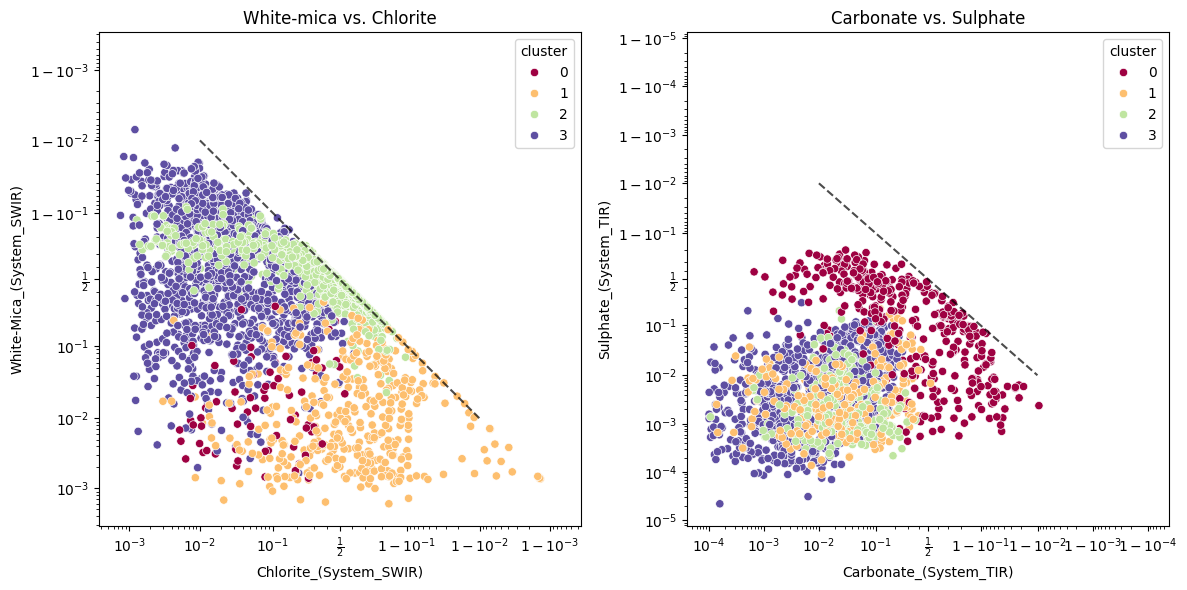

In [77]:
df_minerals['cluster'] = cluster_labels
x_point = 0.5
y_point = 0.5
slope = -1
x_values = np.linspace(0,1,100)
y_values = slope * (x_values - x_point) + y_point
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Subplot 1: White-mica vs. Chlorite
sns.scatterplot(x='Chlorite_(System_SWIR)', y='White-Mica_(System_SWIR)',
                hue='cluster', data=df_minerals,
                palette='Spectral', ax=axes[0])
axes[0].plot(x_values,y_values, linestyle='--',color='k',alpha=0.7)
axes[0].set_title('White-mica vs. Chlorite')
axes[0].set_xscale('logit')
axes[0].set_yscale('logit')

# Subplot 2: Carbonate vs. Sulphate
sns.scatterplot(x='Carbonate_(System_TIR)', y='Sulphate_(System_TIR)',
                hue='cluster', data=df_minerals,
                palette='Spectral', ax=axes[1])
axes[1].plot(x_values,y_values, linestyle='--',color='k',alpha=0.7)
axes[1].set_title('Carbonate vs. Sulphate')
axes[1].set_xscale('logit')
axes[1].set_yscale('logit')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Figure 14.** Two figures with chlorite vs white-mica and carbonate vs sulphate abundances are plotted colored by cluster and in the logit scale. A dashed line indicates the boundary at which combined abundances equals 1. Data points at which only the two displayed minerals make up the total abundance will fall along this line. White-micas and chlorites often appear together, and many make up all or most of a section of the drilled core. Sulphates and carbonates are not quite as common but there are a couple of sections with only these two minerals. The clusters are still defined quite well in these plots, especially for white-mica vs chlorite, where data points with high abundances for both minerals have a well-defined cluster, and high white-mica abundance has a well-defined cluster as well. White-micas and chlorites are both formed in low-grade metamorphic rocks so the abundances here are expected. Carbonate minerals occur mostly in sedimentary rocks, like sulphate minerals, however they normally form in different environments which explains the lower abundance of both being in a rock column. Gypsum, however, can form from a reaction between sulphates and calcium carbonates, so the cluster with high abundances of both could be due to gypsum deposits.

### HDBSCAN with UMAP

Unlike KMeans, HDBSCAN automatically sets the optimal number of clusters. It also classifies some points as outliers. HDBSCAN groups data based on density, however it can be scored through the same methods as KMeans.

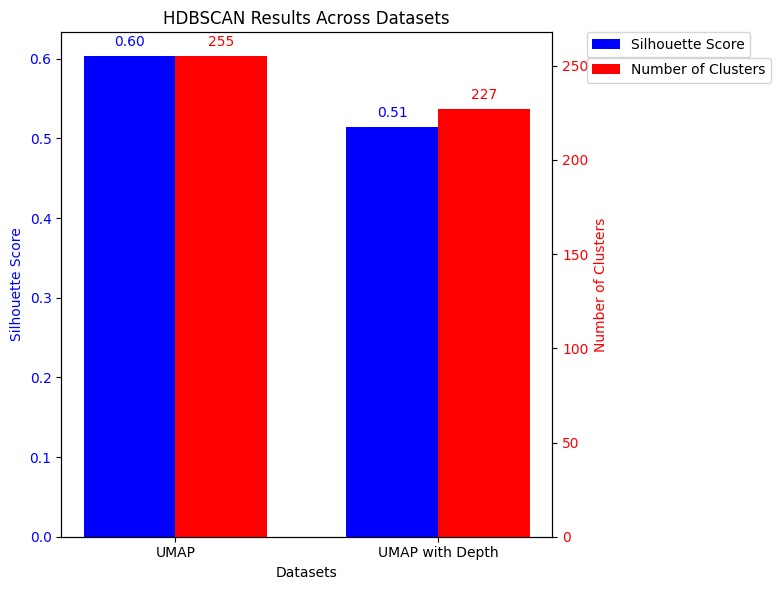

In [78]:
datasets = [df_umap, df_umap_depth]
dataset_labels = ['UMAP','UMAP with Depth']
results = []

for idx, data in enumerate(datasets):
    clusterer = HDBSCAN()
    clusterer.fit(data)

    labels = clusterer.labels_

    # Exclude noise points for silhouette score
    valid_points = labels != -1
    if np.sum(valid_points) > 1 and len(set(labels[valid_points])) > 1:
        silhouette_avg = silhouette_score(data[valid_points], labels[valid_points])
    else:
        silhouette_avg = np.nan  # Handle cases with too few points or clusters

    # Number of clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    results.append((dataset_labels[idx], silhouette_avg, n_clusters))

# Separate results for plotting
labels, silhouette_scores, cluster_counts = zip(*results)

# Plotting with side-by-side bars
bar_width = 0.35  # Width of the bars
x = np.arange(len(labels))  # Dataset indices

fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot for silhouette scores (shifted left by half the bar width)
ax1.bar(x - bar_width / 2, silhouette_scores, bar_width, label="Silhouette Score", color="blue")
ax1.set_xlabel("Datasets")
ax1.set_ylabel("Silhouette Score", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("HDBSCAN Results Across Datasets")

# Creating a second y-axis for the number of clusters
ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, cluster_counts, bar_width, label="Number of Clusters", color="red")
ax2.set_ylabel("Number of Clusters", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Adding legends in the upper right corner (without overlapping)
ax1.legend(bbox_to_anchor=(1.07, 1), loc='upper left', borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.07, 0.95), loc='upper left', borderaxespad=0.)

# Annotating bars with values
for i in range(len(labels)):
    ax1.annotate(f"{silhouette_scores[i]:.2f}",
                 xy=(x[i] - bar_width / 2, silhouette_scores[i]),
                 xytext=(0, 5), textcoords="offset points",
                 ha="center", va="bottom", color="blue")

    ax2.annotate(f"{cluster_counts[i]}",
                 xy=(x[i] + bar_width / 2, cluster_counts[i]),
                 xytext=(0, 5), textcoords="offset points",
                 ha="center", va="bottom", color="red")

# Adjust x-ticks for better readability
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

plt.tight_layout()
plt.show()

**Figure 15.** The results of HDBSCAN on the two UMAP components and the dataset where depth was added. While silhouette score is only slightly higher than
kmeans, the number of clusters is extremely high. This method does not produce results that are easy to explore thus it will not be studied further.

### UMAP Conclusions:

While this method did not allow the same process of evaluation as PCA, its non-linear approach allowed data to be reduced to a very explorable dataset. Using this data for clustering proved to be effective with the KMeans method. After evaluating clustering results with the original data, groupings were still very clear. Bridging relationships between minerals was a bit more difficult than PCA but was still possible, and employing another machine learning approach allowed even more analysis. Through the final analysis, using the KMeans method, high white-mica and chlorite abundances were clustered together which was determined to be due to these data points representing metamorphic columns. Another cluster also showed possible gypsum deposits. More analytical processes went into UMAP in order to be useful for geologic pattern analysis, but it still proved to be useful.

## Analysis Review

**Which method did you like the most?**

For the purpose of the project in identifying mineralogic patterns, PCA was the most useful method I found. Utilizing its loading matrix, which displayed correlations between the original features and the reduced components, it was quickly determined that there were several observations to be further explored.

With respect to machine learning processes, UMAP with KMeans was my favorite. UMAP proved to be very effective at arranging all features into only two components. This was confirmed with KMeans clustering results that were still clearly defined among the original 35 features.

**Which method did you like the least?**

HDBSCAN was my least favorite method. It's automatic cluster numbering lead to extremely large cluster numbers with only a small increase in silhouette score over KMeans. It didn't have any applicability to the intended project by adding more complications where the attempt was to make it simpler.

**How did you score these unsupervised models?**

PCA was scored by explained variance, which measured how similar reduced data was to the original. UMAP couldn't be scored this way and trustworthiness was used instead. UMAP was also evaluated qualitatively by assessing clustering results from reduced components to the original. Clustering results were scored through silhouette score which measures each data point's closeness to other points in its cluster vs points in others.

**Did the output align with your geologic understanding?**

The outputs lead to some expected geologic patterns, including minerals associated with metamorphic rocks appearing together more often than others, and the potential finding of a gypsum deposit.

**What did you want to learn more about?**

I wanted to learn more about the relationships between different minerals and engage in further practice with unsupervised learning techniques. I learned a lot more about dimensionality reduction than I expected and found them to be very useful machine learning methods both by themselves and paired with others.

**Did you pre-process your data?**

Data was preprocessed by combining 16 drill core measurements into one dataset, filling missing features, and dropping unneeded features. The dataset was then standardized which is recommended for more meaningful unsupervised results and the depth feature was dropped for dimensionality reduction.

**What was a decision you were most unsure about?**

Depth is a key feature when exploring geologic patterns. There is no doubt in the geologic community that different processes occur between rocks at different depths. However, including this feature in the dimensionality reduction and/or clustering analysis would add an added complexity to an already complex dataset. Through UMAP with KMeans clustering, I found that even with depth excluded, clusters still grouped clearly when plotted against it. The mineral abundances already adhere to depth patterns, which UMAP was able to acknowledge, so excluding it did not harm the analysis.

## Final Conclusion

PCA provided a quick way to observe geologic patterns unrecognized by normal conventions. UMAP expertly simplified complex relationships, and clustering this data with KMeans produced meaningful groupings. This latter method could potentially be further used for finding fascinating deposits. These methods can be applied to the Pilbara Craton and other areas in Western Australia to explore patterns that can help guide lesser studied geologists to better understand mineral coincidences and potentially find interesting deposits.